In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.graphics.gofplots as sm
plt.style.use('seaborn')

# Análise exploratória dos Tweets

In [2]:
df = pd.read_csv('data_for_account_pick.csv', low_memory = False)
columns_keep = ['Conteúdo da Publicação', 'Data da Coleta', 'Data da Publicação',
                'Nᵒ de Curtidas', 'Nᵒ de Compartilhamentos', 'Nᵒ de Seguidores', 
                'Nᵒ Seguindo', 'Total de Publicações', 'Data da Criação da Conta',
                'Hashtags', 'Nota Atribuída', 'join_user']
df = df[columns_keep]

In [3]:
print(f"Número de registros: {df.shape[0]}")

Número de registros: 709847


In [4]:
agg_dict = {'Conteúdo da Publicação': 'count', 'Nᵒ de Curtidas' : 'sum', 
            'Nᵒ de Compartilhamentos': 'sum', 'Nᵒ de Seguidores':'first', 'Nᵒ Seguindo': 'first',
            'Nota Atribuída': 'mean'}
users = df.groupby("join_user").agg(agg_dict).reset_index()
users.columns = ['usuario', 'contagem', 'soma_curtidas', 'soma_compartilhamentos', 'seguidores', 'seguindo', 'nota']
print(f"Total de usuários únicos: {users.shape[0]}")

Total de usuários únicos: 104172


## Características dos usuários

Inicialmente iremos olhar para o comportamento dos usuários, verificando como é a distribuição de tweets, curtidas obtidas, compartilhamentos obtidos e número de seguidores dos usuários.

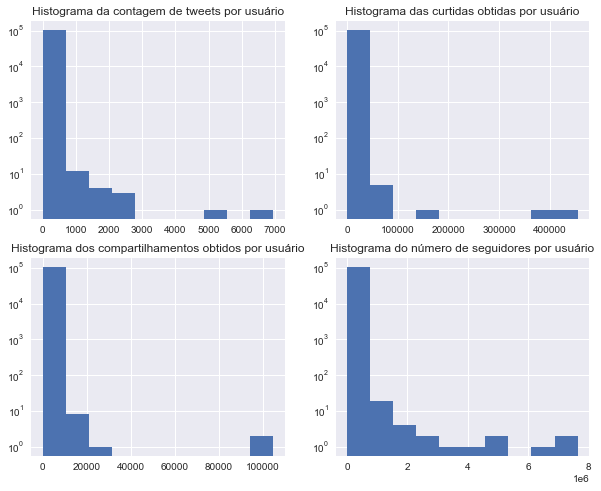

In [5]:
fig, ax = plt.subplots(nrows = 2, ncols = 2)
fig.set_figwidth(10)
fig.set_figheight(8)
ax[0, 0].hist(users.contagem, log = True)
ax[0, 0].set_title("Histograma da contagem de tweets por usuário")
ax[0, 1].hist(users.soma_curtidas, log = True)
ax[0, 1].set_title("Histograma das curtidas obtidas por usuário")
ax[1, 0].hist(users.soma_compartilhamentos, log = True)
ax[1, 0].set_title("Histograma dos compartilhamentos obtidos por usuário")
ax[1, 1].hist(users.seguidores, log = True)
ax[1, 1].set_title("Histograma do número de seguidores por usuário")
plt.show()

Vemos que os dados são formados por uma grande maioria de usuários que utilizam pouco a rede, com poucas postagens e curtidas obtidas, enquanto alguns perfis são os principais geradores de conteúdo. Podemos verificar se há correlação entre essas variáveis, por exemplo, podemos verificar se os usuários com menores notas médias são aqueles que possuem maior quantidade de tweets publicados.

In [6]:
corr = users[['contagem', 'soma_curtidas', 'soma_compartilhamentos', 'seguidores', 'nota']].corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

,contagem,soma_curtidas,soma_compartilhamentos,seguidores,nota
contagem,1.00,0.06,0.10,0.00,-0.04
soma_curtidas,0.06,1.00,0.99,0.05,-0.00
soma_compartilhamentos,0.10,0.99,1.00,0.05,-0.00
seguidores,0.00,0.05,0.05,1.00,0.01
nota,-0.04,-0.00,-0.00,0.01,1.00


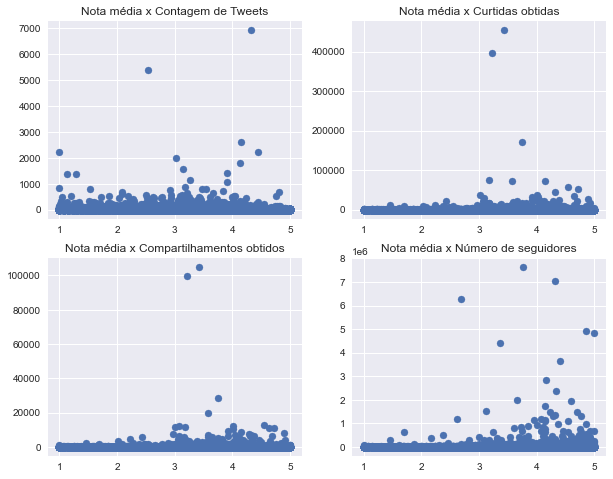

In [7]:
fig, ax = plt.subplots(nrows = 2, ncols = 2)
fig.set_figwidth(10)
fig.set_figheight(8)
ax[0, 0].scatter(users.nota, users.contagem)
ax[0, 0].set_title("Nota média x Contagem de Tweets")
ax[0, 1].scatter(users.nota, users.soma_curtidas)
ax[0, 1].set_title("Nota média x Curtidas obtidas")
ax[1, 0].scatter(users.nota,users.soma_compartilhamentos)
ax[1, 0].set_title("Nota média x Compartilhamentos obtidos")
ax[1, 1].scatter(users.nota, users.seguidores)
ax[1, 1].set_title("Nota média x Número de seguidores")
plt.show()

Vemos no entanto que as correlações obtidas entre as variáveis são mínimas, a única significante obtida é a correlação entre o número total de curtidas obtido e o número total de compartilhamentos obtido.

## Comportamento temporal

Podemos analisar se os tweets apresentaram algum padrão ao longo do tempo, alguma variação no número de curtidas, de tweets publicados. Para isso podemos separar o tempo em intervalos e calcular médias para cada um dos interavalos.

In [8]:
df['data_publicacao'] = pd.to_datetime(df['Data da Publicação'])
print(f"Publicação mais antiga: {df.data_publicacao.min()}")
print(f"Publicação mais recente: {df.data_publicacao.max()}")
df['mes'] = df.data_publicacao.apply(lambda x : x.month)
df['ano'] = df.data_publicacao.apply(lambda x : x.year)
agg_dict = {'Conteúdo da Publicação': 'count', 'Nᵒ de Curtidas' : 'sum', 
            'Nᵒ de Compartilhamentos': 'sum', 'Nota Atribuída': 'mean'}
month_data = df.groupby(['ano', 'mes']).agg(agg_dict).reset_index()
month_data.columns = ['ano', 'mes', 'contagem', 'soma_curtidas', 'soma_compartilhamentos', 'nota']

Publicação mais antiga: 2020-05-13 16:40:00
Publicação mais recente: 2021-04-28 18:53:00


Os dados começaram a ser coletados em agosto de 2020, com apenas alguns dos meses anteriores. Podemos notar que a atividade nas redes sociais sobre o tema de coronavírus tiveram dois picos no período, um primeiro em outubro, seguido por um período de menos atividade e um outro pico (maior) em março. Outra característica interessante é que a nota média dos tweets diminui ao longo do meses, indicando um maior nível de desinformação no final do período.

In [9]:
most_active_users = users.sort_values('contagem', ascending = False).usuario.iloc[0:20].tolist()
selected_data = df[df.join_user.isin(most_active_users)]
agg_dict = {'Conteúdo da Publicação': 'count', 'Nᵒ de Curtidas' : 'sum', 
            'Nᵒ de Compartilhamentos': 'sum', 'Nota Atribuída': 'mean'}
selected_data = selected_data.groupby(['join_user','ano', 'mes']).agg(agg_dict).reset_index()
selected_data.columns = ['usuario', 'ano', 'mes', 'contagem', 'soma_curtidas',
                        'soma_compartilhamentos', 'nota']
selected_data['ano_mes'] = selected_data['ano'].apply(str) + "-" + selected_data['mes'].apply(str)
date_to_index = {'2020-5': 0, '2020-6': 1, '2020-7': 2, '2020-8': 3, '2020-9': 4, '2020-10': 5,
                '2020-11': 6, '2020-12': 7, '2021-1': 8, '2021-2': 9, '2021-3': 10, '2021-4': 11}
selected_data['indice'] = selected_data['ano_mes'].map(date_to_index)

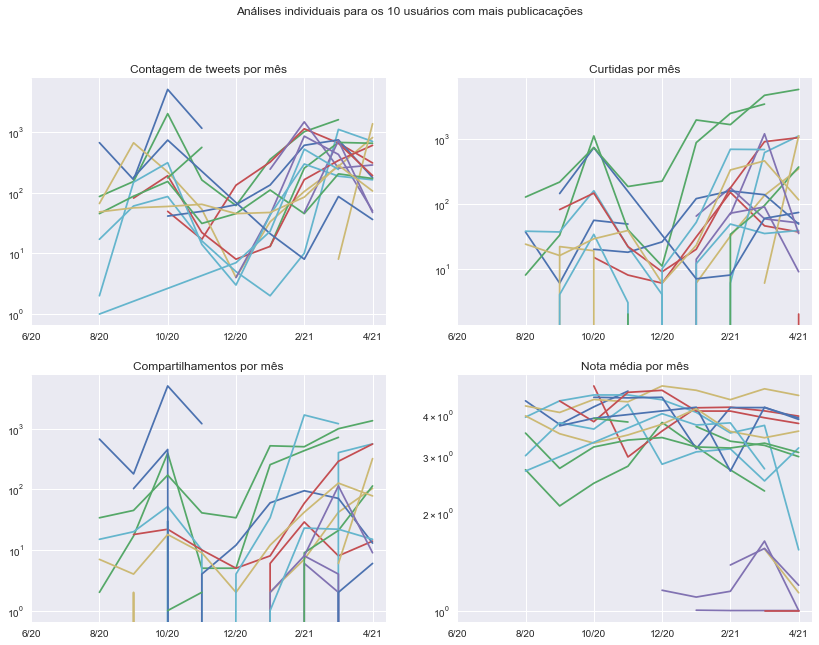

In [10]:
fig, ax = plt.subplots(nrows = 2, ncols = 2)
fig.set_figwidth(14)
fig.set_figheight(10)
fig.suptitle("Análises individuais para os 10 usuários com mais publicacações")
for user in most_active_users:
    cur_data = selected_data[selected_data.usuario == user]
    ax[0, 0].plot(cur_data.indice, cur_data.contagem)
    ax[0, 1].plot(cur_data.indice, cur_data.soma_curtidas)
    ax[1, 0].plot(cur_data.indice,cur_data.soma_compartilhamentos)
    ax[1, 1].plot(cur_data.indice, cur_data.nota)
    
ax[0, 0].set_title("Contagem de tweets por mês")
ax[0, 1].set_title("Curtidas por mês")
ax[1, 0].set_title("Compartilhamentos por mês")
ax[1, 1].set_title("Nota média por mês")
for i in range(2):
    for j in range(2):
        ax[i, j].set_yscale('log')
        ax[i, j].set_xticks([i*2+1 for i in range(6)])
        ax[i, j].set_xticklabels(["6/20", "8/20", "10/20", "12/20", "2/21", "4/21"])
plt.show()